In [5]:
import duckdb
import pandas as pd

In [6]:
# Load the data in
financial_table = duckdb.read_csv('data/business-financial-data-march-2024-csv.csv')
employee_table = duckdb.read_csv('data/machine-readable-business-employment-data-mar-2024-quarter.csv')

### Questions

1. Of the industries where salaries and wages data did NOT exist in 2016 and only appeared later, which industry had the highest average value for actual filled jobs across time and what was that value?

2. Provide the answer and write a DuckDB SQL query to show which year/month combination and industry had the second highest seasonally adjusted operating income sales across all business industries in New Zealand that are categorised as NZSIOC level 2.

3. Create a DuckDB SQL query to calculate the quarterly cumulative number of filled jobs over time for the territorial authority with the highest average value of filled jobs across time. **You may not use window functions in your query.**

4. Assume these datasets are used in part of a pipeline where the file that arrives may contain unwanted duplicates, incorrect datatypes, missing dates or other data quality aberrations. What things could be done programmatically to make sure the input data is of adequate quality and improve the pipeline?

5. Create summary statistics and perform a statistical analysis or create a model using the provided datasets. We are interested in your justification for your choices and reasoning. You may join the data to other datasets from https://www.stats.govt.nz/large-datasets/csv-files-for-download/ if you wish.


### 1. 


In [7]:
query = """
WITH industries_with_salaries_2016 AS (
    SELECT DISTINCT
        Series_title_2 AS Industry
    FROM
        financial_table
    WHERE
        Series_title_1 = 'Salaries and wages'
        AND strftime('%Y-%m', strptime(CAST(Period AS VARCHAR), '%Y.%m')) BETWEEN '2016-01' AND '2016-12'
),
industries_with_salaries_after_2016 AS (
    SELECT DISTINCT
        Series_title_2 AS Industry
    FROM
        financial_table
    WHERE
        Series_title_1 = 'Salaries and wages'
        AND strftime('%Y-%m', strptime(CAST(Period AS VARCHAR), '%Y.%m')) > '2016-12'
),
industries_of_interest AS (
    SELECT
        Industry
    FROM
        industries_with_salaries_after_2016
    WHERE
        Industry NOT IN (SELECT Industry FROM industries_with_salaries_2016) -- select from previous CTE
),
average_filled_jobs AS (
    SELECT
        Series_title_2 AS Industry,
        AVG(Data_value) AS Average_Filled_Jobs
    FROM
        employee_table
    WHERE
        Series_title_1 = 'Filled jobs'
        AND Series_title_3 = 'Actual'
        AND "Group" = 'Industry by employment variable'
        AND Series_title_2 IN (SELECT Industry FROM industries_of_interest)
    GROUP BY
        Series_title_2
)
SELECT
    Industry,
    Average_Filled_Jobs
FROM
    average_filled_jobs
ORDER BY
    Average_Filled_Jobs DESC
LIMIT 1;
"""

duckdb.sql(query)

┌──────────────┬─────────────────────┐
│   Industry   │ Average_Filled_Jobs │
│   varchar    │       double        │
├──────────────┼─────────────────────┤
│ Retail Trade │  194053.71153846153 │
└──────────────┴─────────────────────┘

Answer: Retail Trade, with a value of 194053

### 2.

In [10]:
query = """
WITH filtered_data AS (
    SELECT
        Period,
        Series_title_2 AS Industry,
        Data_value AS Operating_Income
    FROM
        financial_table
    WHERE
        "Group" = 'Industry by financial variable (NZSIOC Level 2)'
        AND Series_title_1 = 'Sales (operating income)'
        AND Series_title_4 = 'Seasonally adjusted'
)
SELECT
    Period,
    Industry,
    Operating_Income
FROM
    filtered_data
ORDER BY
    Operating_Income DESC
LIMIT 1 OFFSET 1;
"""

duckdb.sql(query)

┌─────────┬─────────────────┬──────────────────┐
│ Period  │    Industry     │ Operating_Income │
│ double  │     varchar     │      double      │
├─────────┼─────────────────┼──────────────────┤
│ 2023.03 │ Wholesale Trade │        38810.022 │
└─────────┴─────────────────┴──────────────────┘

Answer: Wholesale Trade for the period of March 2023, with a value of 38810

### 3.

In [11]:
query = """
WITH avg_filled_jobs AS (
    SELECT
        Series_title_2 AS Territorial_Authority,
        AVG(Data_value) AS Average_Filled_Jobs
    FROM
        employee_table
    WHERE
        Series_title_1 = 'Filled jobs'
        AND "Group" = 'Territorial authority by employment variable'
    GROUP BY
        Series_title_2
),
highest_avg_filled_jobs AS (
    SELECT
        Territorial_Authority 
    FROM
        avg_filled_jobs
    ORDER BY
        Average_Filled_Jobs DESC
    LIMIT 1
),
filtered_filled_jobs AS (
    SELECT
        Period,
        Data_value AS Filled_Jobs
    FROM
        employee_table
    WHERE
        Series_title_1 = 'Filled jobs'
        AND "Group" = 'Territorial authority by employment variable'
        AND Series_title_2 = (SELECT Territorial_Authority FROM highest_avg_filled_jobs)
)
SELECT
    a.Period,
    SUM(b.Filled_jobs) AS Cumulative_Filled_Jobs
FROM
    filtered_filled_jobs a
JOIN
    filtered_filled_jobs b
ON
    strftime('%Y-%m', strptime(CAST(a.Period AS VARCHAR), '%Y.%m')) >= strftime('%Y-%m', strptime(CAST(b.Period AS VARCHAR), '%Y.%m'))
GROUP BY
    a.Period
ORDER BY
    a.Period;
"""

duckdb.sql(query)

# generate the markdown for the table
# print(duckdb.sql(query).to_df().to_markdown(floatfmt=("", ".2f", ".0f")))

┌─────────┬────────────────────────┐
│ Period  │ Cumulative_Filled_Jobs │
│ double  │         double         │
├─────────┼────────────────────────┤
│ 2011.06 │               558627.0 │
│ 2011.09 │              1124066.0 │
│ 2011.12 │              1697795.0 │
│ 2012.03 │              2258168.0 │
│ 2012.06 │              2831106.0 │
│ 2012.09 │              3401783.0 │
│ 2012.12 │              3981507.0 │
│ 2013.03 │              4556314.0 │
│ 2013.06 │              5145225.0 │
│ 2013.09 │              5731581.0 │
│    ·    │                  ·     │
│    ·    │                  ·     │
│    ·    │                  ·     │
│ 2021.12 │             28076457.0 │
│ 2022.03 │             28818348.0 │
│ 2022.06 │             29565489.0 │
│ 2022.09 │             30314636.0 │
│ 2022.12 │             31080627.0 │
│ 2023.03 │             31847062.0 │
│ 2023.06 │             32629158.0 │
│ 2023.09 │             33411797.0 │
│ 2023.12 │             34207477.0 │
│ 2024.03 │             34995011.0 │
├

Answer:

|    |   Period |   Cumulative_Filled_Jobs |
|---:|---------:|-------------------------:|
|  0 |  2011.06 |                   558627 |
|  1 |  2011.09 |                  1124066 |
|  2 |  2011.12 |                  1697795 |
|  3 |  2012.03 |                  2258168 |
|  4 |  2012.06 |                  2831106 |
|  5 |  2012.09 |                  3401783 |
|  6 |  2012.12 |                  3981507 |
|  7 |  2013.03 |                  4556314 |
|  8 |  2013.06 |                  5145225 |
|  9 |  2013.09 |                  5731581 |
| 10 |  2013.12 |                  6330161 |
| 11 |  2014.03 |                  6922160 |
| 12 |  2014.06 |                  7526621 |
| 13 |  2014.09 |                  8132406 |
| 14 |  2014.12 |                  8752492 |
| 15 |  2015.03 |                  9367389 |
| 16 |  2015.06 |                  9997399 |
| 17 |  2015.09 |                 10626104 |
| 18 |  2015.12 |                 11270280 |
| 19 |  2016.03 |                 11909214 |
| 20 |  2016.06 |                 12563929 |
| 21 |  2016.09 |                 13219310 |
| 22 |  2016.12 |                 13890926 |
| 23 |  2017.03 |                 14557170 |
| 24 |  2017.06 |                 15241101 |
| 25 |  2017.09 |                 15922806 |
| 26 |  2017.12 |                 16618464 |
| 27 |  2018.03 |                 17316219 |
| 28 |  2018.06 |                 18013628 |
| 29 |  2018.09 |                 18705412 |
| 30 |  2018.12 |                 19413967 |
| 31 |  2019.03 |                 20117168 |
| 32 |  2019.06 |                 20829142 |
| 33 |  2019.09 |                 21539945 |
| 34 |  2019.12 |                 22268793 |
| 35 |  2020.03 |                 22990824 |
| 36 |  2020.06 |                 23712077 |
| 37 |  2020.09 |                 24426583 |
| 38 |  2020.12 |                 25148075 |
| 39 |  2021.03 |                 25863846 |
| 40 |  2021.06 |                 26593592 |
| 41 |  2021.09 |                 27327830 |
| 42 |  2021.12 |                 28076457 |
| 43 |  2022.03 |                 28818348 |
| 44 |  2022.06 |                 29565489 |
| 45 |  2022.09 |                 30314636 |
| 46 |  2022.12 |                 31080627 |
| 47 |  2023.03 |                 31847062 |
| 48 |  2023.06 |                 32629158 |
| 49 |  2023.09 |                 33411797 |
| 50 |  2023.12 |                 34207477 |
| 51 |  2024.03 |                 34995011 |


### 4. 

There are a few things to try: 

- In general, it would be best to enforce some kind of data schema to address the issues of incorrect datatypes. For example, PySpark has the "StructType" and "StructField" objects which would allow you to define all the columns of your dataset, including the mandatory datatypes and include options such as whether NULL values are allowed. It would also be important to check for consistency with other columns as well, for example using the datasets above, we would want to ensure that in the employee dataset that only known territorial authorities are available when the group is selected as "Territorial authority by employment variable".

- Duplicate values that are unwanted (such as from data that doesn't contain a timestamp, or in data that has duplicate IDs), can be dropped using something like the drop_duplicates method from pandas. 

- Missing values can be handled through imputation, however the approach differs depending on the nature of the missingness. For example, if the missing values are identified to be Not Missing At Random then it may be possible with domain knowledge to explicitly model the original process that generated the data, and then fill in the missing values that way. In contrast, if the missing values are Missing Completely At Random, then you may have to settle for a naive form of imputation such as imputing the mean, median or mode, or implement multiple imputation by using other columns in the dataset to inform the choice of value to impute.

- Missing dates are slightly tricker depending on your implementation. If you are using a library such as pandas in your pipeline, then it would be simpler to use something like the reindex method to automatically impute any missing dates. Otherwise, for languages such as PySpark or SQL, you would need to try something like generating a DataFrame with all the available dates, then performing a join onto the DataFrame with the missing dates so that the missing dates are essentially "filled" in if there was not a match. 
  
- It would also be wise for some fields to implement statistical integrity checks. An example of this would be checking whether or not a column comes from a normal distribution. A test for this can be implemented using something like the "normaltest" module from the Scipy stats library. 
  
- Checks such as the above would best be integrated as part of the data pipeline. An example would be using a workflow orchestration library such as Apache Airflow or Prefect. Both options would allow you to define data validation checks (such as for incorrect datatypes or implementing distribution checks) as functions and use those checks on either the input or output of a transformation.

<!-- - 
- For addressing as part of the data pipeline it would be best to drop duplicates i.e. pandas as the drop_duplicates() method.
- For incorrect data types, you may want to provide a schema  -->

### 5.

In [12]:
pd.set_option('display.max_columns', None)

# read files in
fin = pd.read_csv("data/business-financial-data-march-2024-csv.csv")
emp = pd.read_csv("data/machine-readable-business-employment-data-mar-2024-quarter.csv")

In [13]:
# join datasets together

filtered_emp = emp[emp['Group'] == 'Industry by employment variable']
pivot_emp = filtered_emp.pivot_table(index=['Period', 'Series_title_2'], columns=['Series_title_1', 'Series_title_3'], values='Data_value').reset_index()

In [14]:
pivot_emp.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_emp.columns.values]

In [15]:
filtered_fin = fin[fin['Group'] == 'Industry by financial variable (NZSIOC Level 2)']

# first filter by nzsioc level 2
pivot_fin = filtered_fin.pivot_table(index=['Period', 'Series_title_2'], columns=['Series_title_1', 'Series_title_4'], values='Data_value').reset_index()

In [16]:
pivot_fin.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_fin.columns.values]

In [17]:
# join datasets to each other
joined = pivot_emp.merge(pivot_fin, on=['Period',"Series_title_2"], how="inner")

In [18]:
# read additional files in
employers = pd.read_csv('data/enterprise-counts-march-2023-csv-tables.csv')
employers_ind = employers[employers['Group'] == 'Enterprise Counts by Industry']

In [19]:
joined_employers = joined.merge(employers_ind[['Period', 'Data_value', 'Series_title_2']], on=["Period", "Series_title_2"], how="inner")

In [20]:
joined = joined_employers.rename(columns={"Data_value": "Enterprise Count", "Series_title_2": "Industry"})

In [21]:
joined['Period'] = joined['Period'].astype(str)
joined[['Year', 'Month']] = joined['Period'].str.split('.', expand=True)


# Convert to categorical data types
joined['Year'] = joined['Year'].astype('category')
joined['Month'] = joined['Month'].astype('category')

# Apply One-Hot Encoding to 'year' and 'month'
joined_date = pd.get_dummies(joined, columns=['Year', 'Month'])

In [22]:
industry_df = joined_date.drop('Period', axis=1)

In [23]:
# create additional features

# Jobs per enterprise
industry_df['Jobs_per_Enterprise'] = industry_df['Filled jobs_Actual'] / industry_df['Enterprise Count']

# Earnings per enterprise
industry_df['Earnings_per_Enterprise'] = industry_df['Total earnings_Actual'] / industry_df['Enterprise Count']

# Profit per enterprise
industry_df['Profit_per_Enterprise'] = industry_df['Operating profit_Unadjusted'] / industry_df['Enterprise Count']

# Expenditure per enterprise
industry_df['Expenditure_per_Enterprise'] = industry_df['Purchases and operating expenditure_Unadjusted'] / industry_df['Enterprise Count']

# Salaries and wages per enterprise
industry_df['Salaries_per_Enterprise'] = industry_df['Salaries and wages_Unadjusted'] / industry_df['Enterprise Count']

# Sales per enterprise (unadjusted)
industry_df['Sales_per_Enterprise'] = industry_df['Sales (operating income)_Unadjusted'] / industry_df['Enterprise Count']


In [24]:
salaries_analysis = industry_df.groupby('Industry')['Salaries and wages_Unadjusted'].mean().sort_values(ascending=False)
print(salaries_analysis)

Industry
Professional, Scientific and Technical Services    3576.600536
Construction                                       3065.705714
Retail Trade                                       2260.783261
Wholesale Trade                                    2004.569500
Transport, Postal and Warehousing                  1630.533750
Health Care and Social Assistance                  1460.657929
Accommodation and Food Services                    1221.181000
Administrative and Support Services                1157.218500
Other Services                                      679.470679
Information Media and Telecommunications            616.283071
Rental, Hiring and Real Estate Services             503.399786
Electricity, Gas, Water and Waste Services          429.667071
Education and Training                              337.594571
Arts and Recreation Services                        247.932714
Mining                                              153.025964
Name: Salaries and wages_Unadjusted, dtype: fl

From summarising the salaries and wages we are able to see that the professional, scientific and technical services have paid out the highest salaries on average across all time (noting that the numbers are in magnitude of 6.)

In [25]:
industry_df = pd.get_dummies(industry_df, columns=['Industry'])
industry_df = industry_df.drop(['Filled jobs_Seasonally adjusted', 'Filled jobs_Trend', 'Sales (operating income)_Seasonally adjusted', 'Sales (operating income)_Trend'], axis=1)

In [26]:
# Correlation matrix
correlation_matrix = industry_df.corr()

# Correlation with Total earnings_Actual
correlation_with_earnings = correlation_matrix['Salaries and wages_Unadjusted'].sort_values(ascending=False)
print("Correlation with Total earnings_Actual:\n", correlation_with_earnings)

Correlation with Total earnings_Actual:
 Salaries and wages_Unadjusted                               1.000000
Total earnings_Actual                                       0.724328
Sales (operating income)_Unadjusted                         0.672819
Industry_Professional, Scientific and Technical Services    0.591539
Filled jobs_Actual                                          0.584838
Operating profit_Unadjusted                                 0.578688
Purchases and operating expenditure_Unadjusted              0.567076
Industry_Construction                                       0.460025
Enterprise Count                                            0.384663
Industry_Retail Trade                                       0.227656
Industry_Wholesale Trade                                    0.186869
Year_2022                                                   0.106534
Industry_Transport, Postal and Warehousing                  0.090586
Year_2023                                                   0.

We can see that there are a few variables, such as total earnings actual, sales (operating income)_unadjusted, that are positively correlated and some that are negatively correlated, such as earnings per enterprise.

We want to fit a model to be able to see to be able to predict what the salary would be given the information from the business data. We choose Lasso regression for this problem, as we are also interested in performing feature selection so that only the most critical features remain in regards to predictive performance (Lasso regression is capable of zeroing out the weights of unimportant features).

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
X = industry_df.drop(columns=['Salaries and wages_Unadjusted'])
y = industry_df['Salaries and wages_Unadjusted']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Standardize the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [30]:
# Define the parameter grid for Lasso regression
param_grid_lasso = {'alpha': [0.1, 1, 10, 100]}

# Initialize Lasso regression model
lasso = Lasso()

# Initialize GridSearchCV for Lasso regression
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_scaled, y_train_scaled)

# Best parameters and score for Lasso regression
print("Best parameters for Lasso regression:", grid_search_lasso.best_params_)
print("Best score for Lasso regression:", -grid_search_lasso.best_score_)# y_test_scaled

Best parameters for Lasso regression: {'alpha': 0.1}
Best score for Lasso regression: 0.09195230948356982


In [31]:
# Use the best Lasso model to make predictions
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_lasso_scaled = best_lasso_model.predict(X_test_scaled)

# Inverse transform the predictions to the original scale
y_pred_lasso = scaler_y.inverse_transform(y_pred_lasso_scaled.reshape(-1, 1)).flatten()

# Evaluate the Lasso model
rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Regression - Root Mean Squared Error (MSE): {rmse_lasso}")
print(f"Lasso Regression - R^2 Score: {r2_lasso}")

Lasso Regression - Root Mean Squared Error (MSE): 328.3849087160721
Lasso Regression - R^2 Score: 0.912038599931091


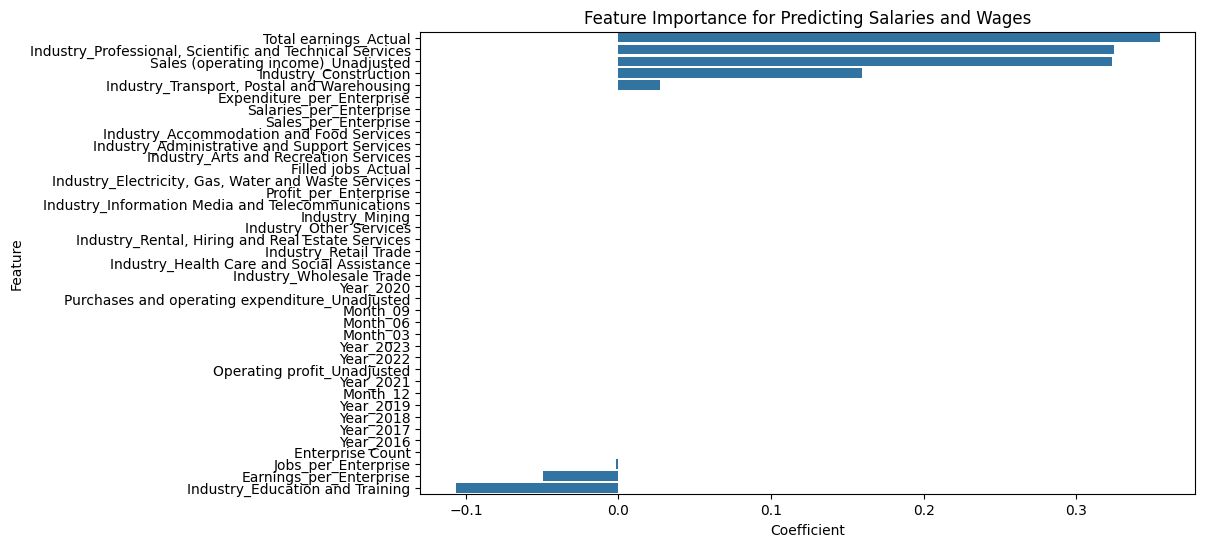

In [32]:
# Get the coefficients of the model
coefficients = best_lasso_model.coef_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance for Predicting Salaries and Wages')
plt.show()

In [33]:
importance_df

,Feature,Coefficient
1,Total earnings_Actual,0.354893
34,"Industry_Professional, Scientific and Technica...",0.324700
4,Sales (operating income)_Unadjusted,0.323048
27,Industry_Construction,0.159386
37,"Industry_Transport, Postal and Warehousing",0.026973
21,Expenditure_per_Enterprise,-0.000000
22,Salaries_per_Enterprise,-0.000000
23,Sales_per_Enterprise,-0.000000
24,Industry_Accommodation and Food Services,0.000000
25,Industry_Administrative and Support Services,0.000000


We can make a few observations:

- We can see that in general high total earnings and operating sales income are good predictors of higher salaries.

- Certain industries are also strong predictors, for example the professional, scientific and technical services industry is correlated with higher salaries. On the other hand, education and training is representative of lower salaries based on the negative coefficient.
  
- A large amount of features were removed using Lasso, including the time features and other industries. For the industries, this may mean that the total earnings were enough to represent the industry itself i.e. the industries have well defined differences in the amount of total earnings, leading there to be no differences using just those features.

Overall, the results seem to imply that certain industries such as Tech or Construction result in higher salaries and wages, perhaps also acting as a proxy for total earnings. 